Data Measurement of DESI Legacy Imaging Surveys ELGs and Lenz 2019 CIB Maps. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import copy
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
plt.style.use("ggplot")

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Lenz+19 data

In this section we measure the CIB-CIB power spectra based on the Lenz+19 data. We use $N_{\rm HI}$ column density masking of $2.5 \times 10^{20}$. 

## Read in data

In [3]:
# parameters 

nulist = ['353', '545', '857']
LMAX = 1500

In [4]:
# Full mission CIB maps in Equatorial coordinate using the original apodization 

data_folder = '/Users/tkarim/research/galCIB/data/cib'
healpy_data_path = '../healpy-weights/'

# now calculate the cross with fullmission and compare where nu != nu'

cl_cibxcib_fullmission = {}
cl_cibxcib_fullmission_beam_corrected = {}
fsky_cross = {}

for nu1 in nulist:
    for nu2 in nulist: 
        
        if nu1 == nu2: # ignore nu == nu' because of auto-noise
            continue 
        
        if int(nu1) > int(nu2): # ignore double counting 
            continue
        
        # multiply by 1e6 to convert Jy to mJy 
        nu1_map = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6
        nu2_map = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6

        # read in relevant masks and calculate effective fsky
        mask_bool1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)
        mask_bool2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)
        mask_bool_eff = mask_bool1 * mask_bool2
        fsky_cross[f'{nu1}x{nu2}'] = mask_bool_eff.sum()/len(mask_bool_eff)
        
        mask_apod1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_apod.hpx.fits")
        mask_apod2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_apod.hpx.fits")

        # calculate power spectra
        cl_fullmission = hp.anafast(
            map1=np.where(mask_bool1, nu1_map, 0.) * mask_apod1,
            map2=np.where(mask_bool2, nu2_map, 0.) * mask_apod2,
            datapath=healpy_data_path, use_pixel_weights=True, pol = False)
            
        cl_cibxcib_fullmission[f'{nu1}x{nu2}'] = cl_fullmission
        
        # beam correction
        beam1 = pd.read_csv(f'{data_folder}/{nu1}/2.5e+20_gp20/windowfunctions.csv', comment='#')['Wl_eff'].values
        beam2 = pd.read_csv(f'{data_folder}/{nu2}/2.5e+20_gp20/windowfunctions.csv', comment='#')['Wl_eff'].values
        
        cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}'] = cl_cibxcib_fullmission[f'{nu1}x{nu2}'][:LMAX]/(beam1*beam2)[:LMAX]

## Power Spectra Measurements where $\nu \neq \nu'$

In this scenario, we can use the fullmission maps. 

## Measured $C (\ell)$ from Lenz+19 

In [5]:
data_lenz19 = pd.read_csv(f"{data_folder}/Cl_CIB_T1T2.csv", comment="#")

## Comparison Plot

In [6]:
# frequencies to compare 

nu1 = '353'
nu2 = '545'

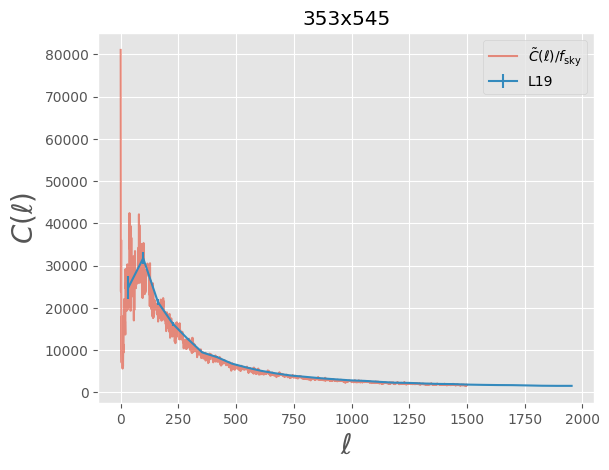

In [10]:
idx = f'{nu1}x{nu2}'

ells = np.arange(LMAX)

# plt.plot(ells, 
#          cl_cibxcib_fullmission_beam_corrected[f'{idx}'],
#          label = r'$\tilde{C} (\ell)$')

plt.plot(ells, 
         cl_cibxcib_fullmission_beam_corrected[f'{idx}']/fsky_cross[f'{idx}'],
         label = r'$\tilde{C} (\ell)/f_{\rm sky}$',
         alpha = 0.6)

plt.errorbar(data_lenz19['ell'], data_lenz19[f'{idx}'], 
             yerr = data_lenz19[f'd{idx}'],
             label = 'L19')

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f"{idx}")
plt.legend(loc='best')


## Full comparison with `NaMaster`

We observe that the agreement is fairly good, when measurement is corrected for $f_{\rm sky}$. However for full comparison, we use `NaMaster`.

In [11]:
import pymaster as nmt

### Estimate $\tilde{C} (\ell)$ using `NaMaster`

In [12]:
# setup NmtField object

# extract apodized masks 

mask_bool1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)
mask_bool2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)

mask_apod1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_apod.hpx.fits")
mask_apod2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_apod.hpx.fits")

mask_nu1 = np.where(mask_bool1, 1, 0) * mask_apod1
mask_nu2 = np.where(mask_bool2, 1, 0) * mask_apod2

# extract data

nu1_map = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6
nu2_map = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6

# remove nans
nu1_map = np.where(mask_bool1, nu1_map, 0)
nu2_map = np.where(mask_bool2, nu2_map, 0)

f1 = nmt.NmtField(mask_nu1, [nu1_map], n_iter=0)
f2 = nmt.NmtField(mask_nu2, [nu2_map], n_iter=0)

In [13]:
pcl_nmt = nmt.compute_coupled_cell(f1, f2)

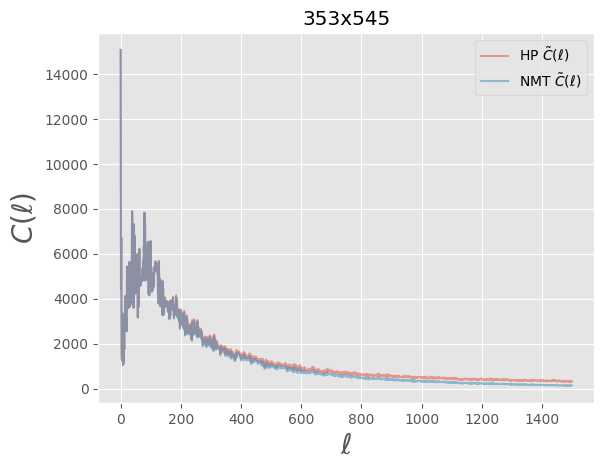

In [14]:
idx = f'{nu1}x{nu2}'

ells = np.arange(LMAX)

plt.plot(ells, 
         cl_cibxcib_fullmission_beam_corrected[f'{idx}'],
         label = r'HP $\tilde{C} (\ell)$',
         alpha = 0.5)

plt.plot(ells, 
         pcl_nmt[0, :LMAX],
         label = r'NMT $\tilde{C} (\ell)$',
         alpha = 0.5)

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f"{idx}")
plt.legend(loc='best')


In [15]:
# fsky from NMT
fsky_nmt = np.mean(f1.get_mask() * f2.get_mask())

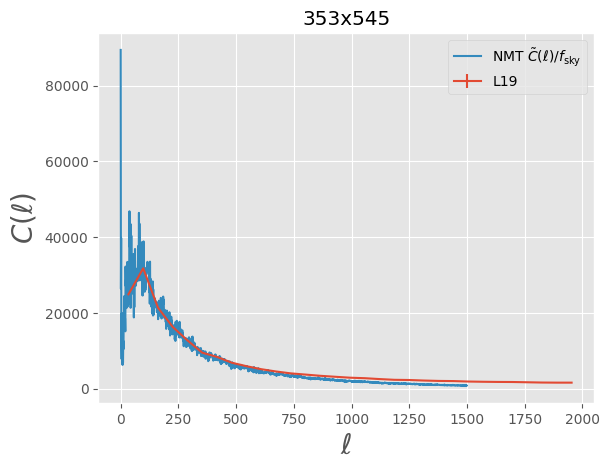

In [17]:
plt.errorbar(data_lenz19['ell'], data_lenz19[f'{idx}'], 
             yerr = data_lenz19[f'd{idx}'],
             label = 'L19')

plt.plot(ells, 
         pcl_nmt[0,:LMAX]/fsky_nmt,
         label = r'NMT $\tilde{C} (\ell)/f_{\rm sky}$')

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f"{idx}")
plt.legend(loc='best')


#### Mode-coupling matrix calculation

In [50]:
nside = 1024

In [42]:
delta_ell = 64
b = nmt.NmtBin.from_nside_linear(1024, nlb=delta_ell)

In [43]:
# NaMaster workspace
w = nmt.NmtWorkspace.from_fields(f1, f2, b)

In [44]:
# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()

# Extract bandpower window functions
Bbl = w.get_bandpower_windows().squeeze()

In [51]:
ls = np.arange(3*nside)

# - binning weights for each bandpower
n_bins = b.get_n_bands()
Fls = np.zeros([n_bins, 3*nside])
for i in range(n_bins):
    Fls[i, b.get_ell_list(i)] = b.get_weight_list(i)

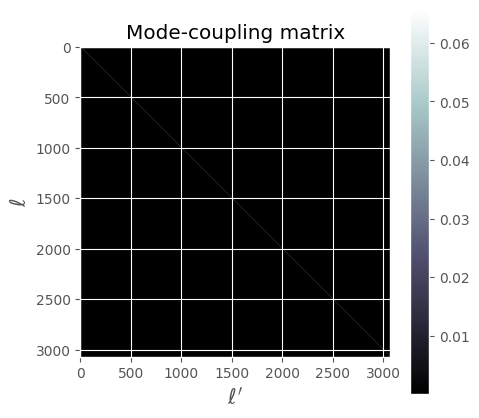

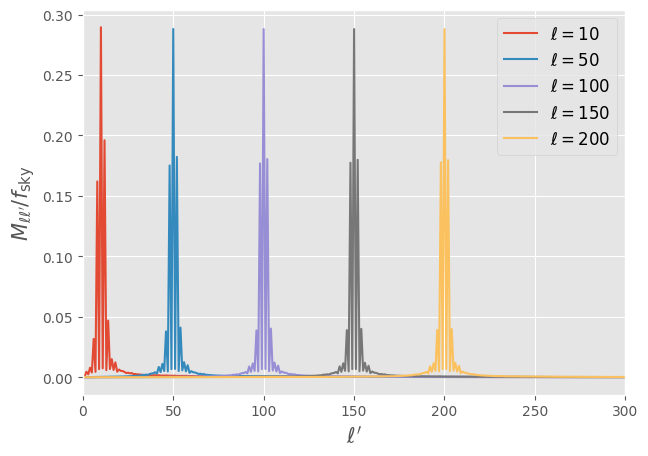

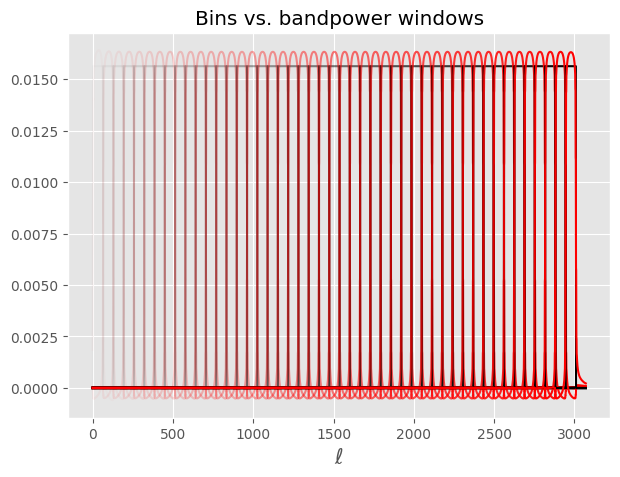

In [52]:


# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()

plt.figure(figsize=(7, 5))
for ll in [10, 50, 100, 150, 200]:
    plt.plot(ls, mcm[ll]/fsky_nmt, label=f'$\\ell={ll}$')
plt.xlabel("$\\ell'$", fontsize=15)
plt.ylabel("$M_{\\ell \\ell'}/f_{\\rm sky}$", fontsize=15)
plt.legend(fontsize=12)
plt.xlim([0, 300])

plt.figure(figsize=(7, 5))
plt.title('Bins vs. bandpower windows')
for i, fl in enumerate(Fls):
    plt.plot(ls, fl, 'k-', alpha=(i+1)/n_bins)
    plt.plot(ls, Bbl[i], 'r-', alpha=(i+1)/n_bins)
plt.xlabel(r'$\ell$', fontsize=15);

In [53]:
print("Sum of MCM over ell': %.5lf" % (np.dot(mcm, np.ones(len(mcm)))[0]))
print("fsky: %.5lf" % fsky_nmt)

Sum of MCM over ell': 0.16052
fsky: 0.16082


0.16287636756896973

In [56]:
.16052/.16082 * fsky_cross[f'{idx}']

0.1625725315394293

In [63]:
cl_dec_nmt = w.decouple_cell(pcl_nmt)

In [65]:
# - effective ells for each bandpower
leff_nmt = b.get_effective_ells()

<ErrorbarContainer object of 3 artists>

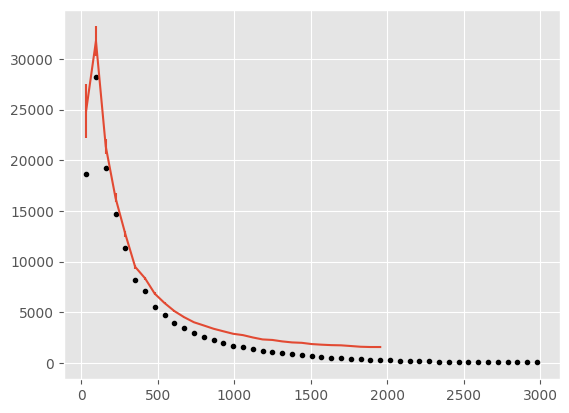

In [77]:
plt.plot(leff_nmt, cl_dec_nmt[0], 'k.')
plt.errorbar(data_lenz19['ell'], data_lenz19[f'{idx}'], 
             yerr = data_lenz19[f'd{idx}'],
             label = 'L19')
# plt.yscale("log")
# plt.xscale("log")